# Introduction

With the importance placed on getting a college degree nowadays ([65 percent of workers have at least some postsecondary education](https://cew.georgetown.edu/cew-reports/americas-divided-recovery/)), students more than ever need to focus on getting into colleges that will best help them achieve their goals. Sites like [US News](https://www.usnews.com/best-colleges) have become the de-facto standard for students trying to search through hundreds of universities and deciding which is the best fit. Specifically, US News' ranking system is given enormous weight, influencing [how schools are perceived by the general public](https://www.forbes.com/sites/robertzafft/2021/12/07/us-news-business-school-rankings-crucial-but-meaningless/).



## Web Scraping
After spending 8 hours or so writing a web scraper to get all the components from the website, it turns out that each page provides JSON objects that contain all the data in a much easier to extract format. Oh well. 

In [38]:
from bs4 import BeautifulSoup

html_doc = open("2022 Best National Universities US News Rankings.htm", encoding="utf8")
soup = BeautifulSoup(html_doc, 'html.parser')

In [39]:
anchors = soup.select('a[class*="card-name"]')
links = list(map(lambda x: x.get('href'), anchors))
print(links[:10])
print(len(links))

['https://www.usnews.com/best-colleges/princeton-university-2627', 'https://www.usnews.com/best-colleges/columbia-university-2707', 'https://www.usnews.com/best-colleges/harvard-university-2155', 'https://www.usnews.com/best-colleges/massachusetts-institute-of-technology-2178', 'https://www.usnews.com/best-colleges/yale-university-1426', 'https://www.usnews.com/best-colleges/stanford-university-1305', 'https://www.usnews.com/best-colleges/university-of-chicago-1774', 'https://www.usnews.com/best-colleges/university-of-pennsylvania-3378', 'https://www.usnews.com/best-colleges/california-institute-of-technology-1131', 'https://www.usnews.com/best-colleges/duke-university-2920']
392


In [40]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json

link = "https://www.usnews.com/best-colleges/princeton-university-2627"

def get_soup_obj(link, subpage):
    url = link + "/" + subpage
    agent = {"User-Agent":'Mozilla/5.0'}
    response = requests.get(url, headers = agent)
    return BeautifulSoup(response.text, 'html.parser')

soup = get_soup_obj(link, "student-life")

Then, we look at the structure of the HTML files and find the line in the script containing the JSON object, and extract it:

In [77]:
def get_json_from_soup(soup_obj):
    script_json_line = soup_obj.find_all("script")[-2].contents[0].split("\n")[4]
    json_obj_str = script_json_line[script_json_line.find("{"):-1].replace("undefined","null")
    json_obj = json.loads(json_obj_str)
        
    base_key = 'src/containers/pages/education/higher-education/colleges/profile'
    json_data = json_obj.get(f'{base_key}/overview.js',False) or \
                json_obj.get(f'{base_key}/generic.js',False) or \
                json_obj.get(f'{base_key}/rankings.js',None)
    
    return json_data['data']['context']['data']['page'] 

The 'fields' data indicates how the data is structured, the 'schoolData' field provides the values, and 'schoolDetails' provides basic info not in 'schoolData'.

We can use these methods to get all the data from every university and put it in a single JSON object, with the university name as the key.

In [ ]:
all_univ_json_data = {}
pages = ["", "overall-rankings", "applying", "academics", "student-life", "paying", "campus-info"]
for link in links:
    json_out = {'fields': {}, 'data': {}}
    for page in pages:
        json_data_fields = get_json_from_soup(get_soup_obj(link,page))
        #print(page + "::" + str(json_data_fields)[:20])
        json_out['data'].update(json_data_fields['schoolData'])
        json_out['fields'].update(json_data_fields['fields'])
    json_out['details'] = get_json_from_soup(get_soup_obj(link,""))['schoolDetails']
    name = json_out['details']['displayName']
    all_univ_json_data[name] = json_out
    print(name)

In [155]:
with open('all_univ.json', 'w') as outfile:
    json.dump(all_univ_json_data, outfile)

### Part 1.2: Data Compression

In [4]:
import json

# Read in the university data
with open('all_univ.json', 'r') as infile:
    all_univ_json_data = json.load(infile)

There are a lot of unnecessary structure in this data that we can remove, to decrease the size of the file (i.e. make it small enough I can upload it to GitHub without using LFS) and make our analysis life a lot easier.

In [5]:
nested_fields = set()

# Add the initial key set for the field and the full (human-readable) name of the field to a dictionary
def create_field_label_keys():
    # Assumes that all of the possible data attributes are contained within the first university on the list
    # Even if this isn't true, it covers a vast majority of use cases, so it's acceptable to me
    key = {}
    # Iterate through fields, putting the labels and fieldNames into a dictionary for future reference
    for field in all_univ_json_data['Princeton University']['fields'].values():
        if 'fieldName' in field:
            key[field['fieldName']] = field['label']
    return key    
    
def get_data_value(univ, field_name):
    return univ['data'][field_name]['rawValue'] if 'rawValue' in univ['data'][field_name] else None

# Given a key, get the value associated, also extracting any nested fields associated with that key. 
def get_field_value(univ, field):
    if 'subFields' in field:
        subfields = {}
        for subfield in field['subFields']:
            subfield_fields = subfield['fields'] if "fields" in subfield else [subfield['field']] 
            for subfield_field in subfield_fields:
                nested_fields.add(subfield_field)
                subfields[subfield_field] = get_data_value(univ, subfield_field)
        return subfields
    else:
        if field['fieldName'] not in nested_fields:
            return get_data_value(univ, field['fieldName'])

# Returns a tuple; the first value is the actual data, the second is the additional part of the key mapping
def get_details_info(univ):
    univ_details = univ['details'].copy()
    univ_details.pop("mainRank")
    univ_details.pop("crossWalk")
    keys = {}
    ranks = {}
    for rank_name, rank_data in univ_details['ranks'].items():
        if rank_data['isPublic'] and not rank_data['locked']:
            keys[rank_name] = rank_data['displayName']
            ranks[rank_name] = rank_data['displayRank']
    univ_details['ranks'] = ranks
    return (univ_details, keys)

univ_keys = create_field_label_keys() # map between field keys and readable labels

all_univ_data = []
for name, univ in list(all_univ_json_data.items()):
    univ_data = {}
    # Add info from 'details'
    details_data, details_keys = get_details_info(univ)
    univ_keys.update(details_keys)
    univ_data.update(details_data)   
    
    for field in univ['fields'].values():
        if field['isPublic']: 
            field_value = get_field_value(univ, field)
            if field_value is not None:
                univ_data[field['fieldName']] = field_value

    all_univ_data.append(univ_data)
    #print(name)

In [6]:
with open('all_univ_compressed.json', 'w') as outfile:
    json.dump(all_univ_data, outfile)
with open('all_univ_compressed_key.json', 'w') as outfile:
    json.dump(univ_keys, outfile)

## Analysis

Loading in the "cleaned-up" data structure:

In [7]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import json

In [65]:
with open('all_univ_compressed.json', 'r') as infile:
    all_univ_data = json.load(infile)
with open('all_univ_compressed_key.json', 'r') as infile:
    data_key = json.load(infile)
univ_df = pd.DataFrame(all_univ_data)

In [66]:
univ_df.head()

,primaryKey,xwalkId,urlName,displayName,shortName,city,state,zip,website,streetAddress1,...,regPctAllCars,schoolStatementText,schoolStatementUrl,schoolStatementUpdateDateTime,dlHousingDeposit,trfMinGpaCol,trfGuaranteedAdmUrl,vInStateTuition,vOutStateTuition,internationalTestReqMichiganTest
0,2627,186131,princeton-university,Princeton University,Princeton University,Princeton,NJ,08544,http://www.princeton.edu,N/A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2707,190150,columbia-university,Columbia University,Columbia University,New York,NY,10027,http://www.columbia.edu,2960 Broadway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2155,166027,harvard-university,Harvard University,Harvard University,Cambridge,MA,02138,http://www.harvard.edu/,N/A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2178,166683,massachusetts-institute-of-technology,Massachusetts Institute of Technology,Massachusetts Institute of Technology,Cambridge,MA,02139,http://web.mit.edu/,77 Massachusetts Avenue,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1426,130794,yale-university,Yale University,Yale University,New Haven,CT,06520,http://www.yale.edu/,N/A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tidy Data, Missing Data
Looking at this data, you may notice that there are many nested values, represented as strings of JSON in this data frame.

In [67]:
univ_df["gStudentGenderDistribution"]

0          {'vPctUnderMen': 50, 'vPctUnderWomen': 50}
1          {'vPctUnderMen': 49, 'vPctUnderWomen': 51}
2          {'vPctUnderMen': 49, 'vPctUnderWomen': 51}
3          {'vPctUnderMen': 52, 'vPctUnderWomen': 48}
4          {'vPctUnderMen': 50, 'vPctUnderWomen': 50}
                            ...                      
387    {'vPctUnderMen': None, 'vPctUnderWomen': None}
388        {'vPctUnderMen': 37, 'vPctUnderWomen': 63}
389        {'vPctUnderMen': 40, 'vPctUnderWomen': 60}
390        {'vPctUnderMen': 45, 'vPctUnderWomen': 55}
391        {'vPctUnderMen': 35, 'vPctUnderWomen': 65}
Name: gStudentGenderDistribution, Length: 392, dtype: object

One way we can deal with variables like these is by using `json_normalize` to split them up into separate columns:

In [68]:
univ_df = pd.json_normalize(univ_df.to_dict('records'), sep="_") # un-nest the nested variables 
univ_df[["gStudentGenderDistribution_vPctUnderMen", "gStudentGenderDistribution_vPctUnderWomen"]]

,gStudentGenderDistribution_vPctUnderMen,gStudentGenderDistribution_vPctUnderWomen
0,50.0,50.0
1,49.0,51.0
2,49.0,51.0
3,52.0,48.0
4,50.0,50.0
...,...,...
387,NaN,NaN
388,37.0,63.0
389,40.0,60.0
390,45.0,55.0


Another thing we need to deal with is the high number of missing data points, which results in the data being untidy -- in other words, there's a lot of columns which are close to empty.

[Text(0.5, 0, 'Number of Rows Missing Data')]

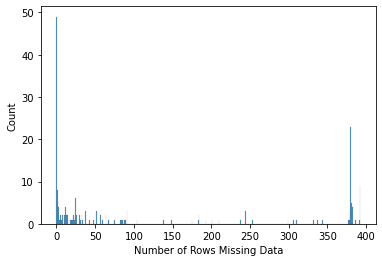

In [69]:
df_nas = univ_df.isna().sum()
ax = sns.histplot(df_nas, discrete=True)
ax.set(xlabel="Number of Rows Missing Data") 

Most of the variables have few to no missing data, but there's a long tail to the right of 0 followed by a massive spike slightly under 400 (indicating that there are some variables where almost none of the rows have that data). For the values where there are too many missing points, the best solution is to just drop them, because they won't be particularly useful in our analysis anyways (since they contribute so little information). Let's use a somewhat arbitrary threshold of one third (so at least 2/3 of the data must be non-null).

In [64]:
univ_df.dropna(axis=1, thresh=len(univ_df)*2//3, inplace=True)
univ_df

,primaryKey,xwalkId,urlName,displayName,shortName,city,state,zip,website,streetAddress1,...,gSororityMembers_stuCatSororityUg,gSororityMembers_stuCatNoSororityUg,csAvgCostIncome_nptLo,csAvgCostIncome_nptMed1,csAvgCostIncome_nptMed2,csAvgCostIncome_nptHi1,csAvgCostIncome_nptHi2,csTypicalDebtIncome_loIncDebtMdn,csTypicalDebtIncome_mdIncDebtMdn,csTypicalDebtIncome_hiIncDebtMdn
0,2627,186131,princeton-university,Princeton University,Princeton University,Princeton,NJ,08544,http://www.princeton.edu,N/A,...,0,100,1386.0,2044.0,7576.0,16989.0,36747.0,3865.0,6001.0,12000.0
1,2707,190150,columbia-university,Columbia University,Columbia University,New York,NY,10027,http://www.columbia.edu,2960 Broadway,...,12,88,8916.0,4287.0,5887.0,18637.0,42199.0,24130.0,16750.0,15000.0
2,2155,166027,harvard-university,Harvard University,Harvard University,Cambridge,MA,02138,http://www.harvard.edu/,N/A,...,0,0,2973.0,1010.0,3411.0,15553.0,46160.0,12500.0,15000.0,10250.0
3,2178,166683,massachusetts-institute-of-technology,Massachusetts Institute of Technology,Massachusetts Institute of Technology,Cambridge,MA,02139,http://web.mit.edu/,77 Massachusetts Avenue,...,26,74,4535.0,1820.0,6049.0,14381.0,38934.0,6993.0,6155.0,13000.0
4,1426,130794,yale-university,Yale University,Yale University,New Haven,CT,06520,http://www.yale.edu/,N/A,...,0,0,2125.0,1647.0,2167.0,11492.0,43417.0,10163.0,8205.0,15857.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,2525,179964,william-woods-university,William Woods University,William Woods University,Fulton,MO,65251,http://www.williamwoods.edu,1 University Avenue,...,0,0,21691.0,26790.0,23510.0,24531.0,26885.0,11083.0,13800.0,16423.0
388,7948,131113,wilmington-university,Wilmington University,Wilmington University,New Castle,DE,19720,http://www.wilmu.edu,320 Dupont Highway,...,0,0,14599.0,15092.0,15400.0,18123.0,NaN,15105.0,15500.0,13971.0
389,2985,199962,wingate-university,Wingate University,Wingate University,Wingate,NC,28174,https://www.wingate.edu/,220 N. Camden Rd.,...,12,88,15876.0,16798.0,17415.0,21569.0,24421.0,9500.0,12000.0,12580.0
390,9168,206604,wright-state,Wright State University,Wright State,Dayton,OH,45435,http://www.wright.edu,3640 Colonel Glenn Highway,...,0,0,13460.0,14755.0,16908.0,19223.0,19515.0,15000.0,14199.0,13500.0


This still leaves us with a large number of data values which have a relatively high number of missing values, however. The way these are handled depends on the situation at hand, so I cannot just deal with them all of them at once. 

### What *Is* The US News Ranking?

US News gives all colleges a score on a scale from 0 to 100, where a higher number is better. This is based on a number of factors which they describe on [their website](https://www.washingtonpost.com/education/2018/09/12/us-news-changed-way-it-ranks-colleges-its-still-ridiculous/). Unfortunately, unless you pay for premium access, you are only able to see a small portion of the factors that go into the ranking:

![image.png](attachment:3abe5a2e-0dae-4dbc-9b16-4c15fa782f62.png)

This means that it's impossible for us to perfectly re-calculate the rankings from this data.  

First, let's take a look at a random sample of the rankings:

In [71]:
univ_df.sample(30)['vDisplayScore']

146            56
288            42
48             70
23             81
248            45
14             88
291            42
226            47
387    Bottom 25%
247            46
20             83
36             76
114            60
174            53
74             65
308    Bottom 25%
216            48
150            55
346    Bottom 25%
137            56
362    Bottom 25%
304    Bottom 25%
38             74
33             77
162            54
240            46
9              93
269            44
298    Bottom 25%
229            47
Name: vDisplayScore, dtype: object

We can see that some of the values, instead of being numeric, are instead the text value "Bottom 25%". This is because US News doesn't report a score for any university in the bottom 25 percent of the data. In order to do a numeric analysis, we have to discard those values. However, this is likely to have an impact on our analysis, so we need to keep it in mind. In data science terms, this data is technically **Missing Not At Random (MNAR)**, because while the rank is dependent on some of the factors that we have in the data set, there are other factors that we can't access that also have an effect (locked only for Premium users). The only statistically appropriate thing to do here is to remove the missing data, then restrict the domain of this analysis -- in other words, **all of the following calculations regarding the university scores only apply to universities in the top 75 percentile of US News rankings**. 

In [72]:
univ_df["vDisplayScoreInt"] = univ_df["vDisplayScore"].apply(lambda x: x if isinstance(x,int) else np.nan)

After that, let's look at the distribution of the remaining scores:

<AxesSubplot:xlabel='vDisplayScoreInt', ylabel='Count'>

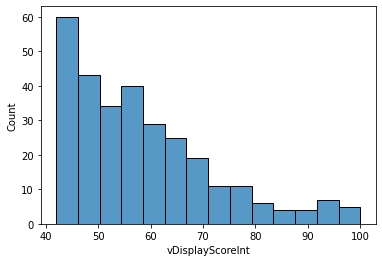

In [73]:
sns.histplot(x="vDisplayScoreInt",data=univ_df,bins=14)

The display scores appear to have a strong rightward skew -- in other words, there are many values in the 40s and 60s, there are only a few with a score of 90 or above. However, despite the ranking scale going from 0 to 100, the minimum value in this data set is only in the low 40s, on account of the missing 25 percent. It's possible (or even likely) that there is supposed to be a similar tail on the left side of this distribution that is not included in the data. 

## Exploring Known Factors For Ranks & Predicting

A non-paying reader of the US News website can only see data about the average graduation rate, student class sizes, and the student-faculty ratio. But how much do those factors matter? Is the correlation between the different factors strong enough that we can predict the rankings using only the factors that we can access for free? 

(**NOTE:** Ordinarily you would do complete EDA (Exploratory Data Analysis) before prediction, but since I already know there is a relationship here I'm going straight into prediction.)

In [74]:
ranking_factors = ["rCAvgPctGrad6Yr", "pellGradRate",  "nonPellGradrate", 
                   "rCPctClasses119", "rCPctClassesGt50", "vStudentFacultyRatio"]
univ_df_known_rank = univ_df[["vDisplayScoreInt"] + ranking_factors]

For one, we need to address the issue with the student-faculty ratio -- namely, that it's a string, not numeric. 

In [75]:
univ_df["vStudentFacultyRatio"] = univ_df["vStudentFacultyRatio"].apply(\
                        lambda x: int(x[:-2]) if pd.notna(x) else np.nan)

Let's also look at the number of missing values in the factors:

In [76]:
temp_rank = univ_df_known_rank.copy().dropna(subset=["vDisplayScoreInt"])
temp_rank.isna().sum()

vDisplayScoreInt        0
rCAvgPctGrad6Yr         0
pellGradRate            8
nonPellGradrate         8
rCPctClasses119         2
rCPctClassesGt50        2
vStudentFacultyRatio    6
dtype: int64

There are few to no missing data values within the set of universities in teh 75th percentile, so dealing with these values is of minor concern. 

US News says that the ranking is calculated by using the "sum" of various factors weighted by some percentages. This implies that we should use a linear regression model -- simply take the values in the data set, scale them based on the percentage weights described on the website, and use that as a predictor. However, in order for this model to make sense, we have to make the assumption that the variables vary linearly with respect to desired output variable (the score). Let's check that graphically:

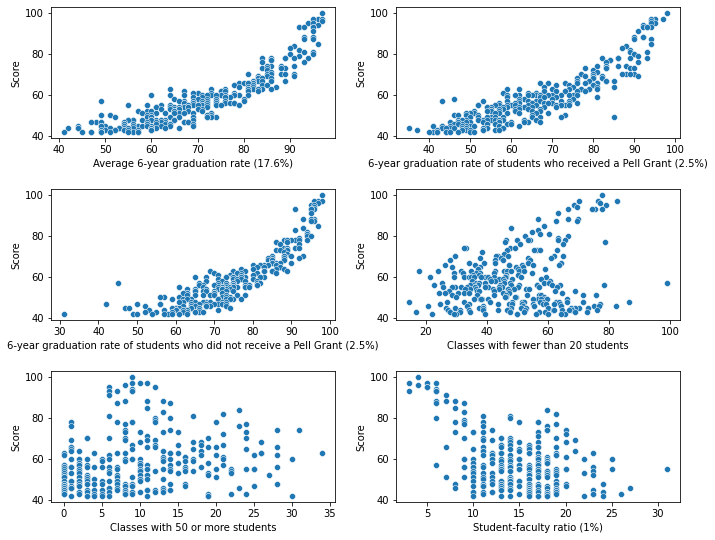

In [21]:
from math import ceil 

def plot_factors_against_score(ranking_factors, ncols, df=univ_df):
    fig, axes = plt.subplots(nrows=ceil(len(ranking_factors)/ncols), ncols=ncols, figsize=(10,8))
    fig.tight_layout(pad=3.0)
    for col, ax in zip(ranking_factors, fig.axes):
        sns.scatterplot(ax=ax, x=col, y="vDisplayScoreInt", data=df)
        ax.set(xlabel=data_key.get(col, col), ylabel="Score")
        
plot_factors_against_score(ranking_factors, 2)

This data is very interesting -- some of these appear to have little to no correlation with the data (specifically those relating to class sizes) and some of these have a quite strong, *non-linear* relationship (specifically those regarding graduation rates). Therefore, a linear model is definitely not a good idea here.

The apparent strength of the graduation rate versus score relationship on the graph makes me wonder about how well a polynomial predictive model could do when input only the 6-year graduation rate (i.e. a single-variable model). After some experimentation, I found that a degree 3 polynomial yields sufficient accuracy while also not overfitting the data.

In [22]:
#https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html
from sklearn.preprocessing import PolynomialFeatures

# Extract the relevant data from the data frame, getting rid of NAs
univ_df_no_na = univ_df[pd.notna(univ_df["vDisplayScoreInt"])]
x = univ_df_no_na["rCAvgPctGrad6Yr"].ravel().reshape(-1, 1)
y = univ_df_no_na["vDisplayScoreInt"]

# Calculate the polynomial feature from the input data
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(x)

[Text(0.5, 32.99999999999995, 'Average 6-year graduation rate (17.6%)'),
 Text(27.125, 0.5, 'Score (out of 100)')]

<Figure size 720x720 with 0 Axes>

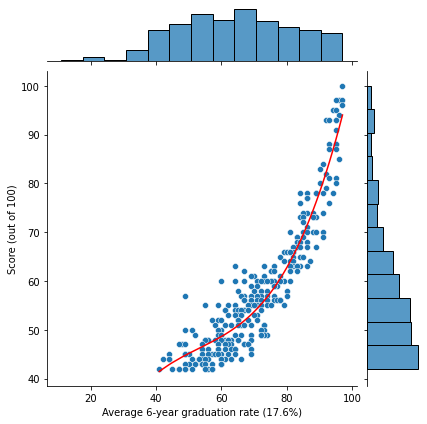

In [23]:
# Generate the model
import statsmodels.api as sm
model = sm.OLS(y,xp).fit()
ypred = model.predict(xp) 

# Display the scatterplot between the graduation rate and score rant, and show histograms of each variable 
plt.figure(figsize=(10, 10))
jp = sns.jointplot(x="rCAvgPctGrad6Yr",y="vDisplayScoreInt",data=univ_df)

# Plot the regression data
x, ypred = zip(*sorted(zip(x, ypred)))
ax = jp.figure.axes[0]
ax.plot(x,ypred, 'r')  
ax.set(xlabel=data_key["rCAvgPctGrad6Yr"], ylabel=data_key["vDisplayScore"])

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       vDisplayScoreInt   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     879.5
Date:                Mon, 20 Dec 2021   Prob (F-statistic):          1.90e-146
Time:                        15:59:38   Log-Likelihood:                -855.14
No. Observations:                 298   AIC:                             1718.
Df Residuals:                     294   BIC:                             1733.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.6150     28.749     -1.065      0.288     -87.196      25.966
x1             3.6685      1.273      2.883      0.004       1.164       6.173
x2            -0.0627      0.018     -3.415      0.001      -0.099      -0.027
x3             0.0004   8.66e-05      4.546      0.000       0.000       0.001
==============================================================================
Omnibus:                        1.801   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.739
Skew:                           0.187   Prob(JB):                        0.419
Kurtosis:                       2.977   Cond. No.                     5.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With an R-squared of 0.9, we can see this is a really good predictor of ranking, even though it apparently only accounts for 17.6 percent of the ranking calculation. Furthermore, the p-values of the various factors are significantly below the standard threshold of 0.05, so they are clearly statistically significant.

#### Transforming The Data
However, it's unusual that the relationship isn't linear. Since these metrics are artificially created by US News, one would expect there to be a more obvious mathematical relationship between the ranking factors and the rank. According to the [US News website](https://www.usnews.com/education/best-colleges/articles/how-us-news-calculated-the-rankings), they "normalize" the values before they are put into the calculation. This may mean that instead of looking at the raw value, we should look at the *z-score* of each ranking, which is a measure that describes how far away from the mean the value is. In fact, US News says that they "z-scored" the *predicted* graduation rate [in the supplementary material on their website](https://www.usnews.com/media/best-colleges/graduation-rate-performance). However, for z-score to be a useful measure, we would also need to make the assumption that scores are normally distributed. Let's check that first, by observation: 

<AxesSubplot:xlabel='rCAvgPctGrad6Yr', ylabel='Count'>

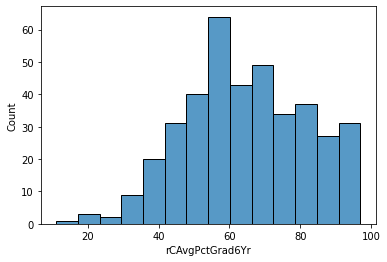

In [25]:
sns.histplot(x="rCAvgPctGrad6Yr",data=univ_df,bins=14)

(Note: this is including the schools with the bottom 25 percent score, which is desired in this case.) 

This data has a meaningful leftward skew. To quantify this more accurately, we can use a QQ plot, which compares the *quantiles* (percentiles) of the sample with what would be expected if the sample was normally distributed. If the sample is perfectly normal, then we would expect to see a perfect line. 

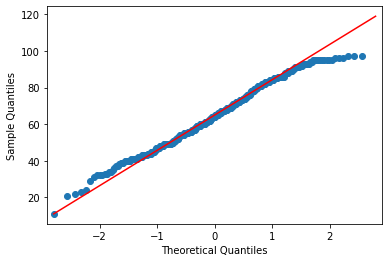

In [26]:
ax = sm.qqplot(univ_df["rCAvgPctGrad6Yr"], line="q")

The deviation from the line at the lower and higher quantiles shows that this isn't exactly normal, so it's unlikely that US News would use this for normalization. We can double-check by looking at the scatterplot with the z-scores:

[Text(0.5, 32.99999999999995, 'Average 6-Year Graduation Percentage (z-score)'),
 Text(27.125, 0.5, 'Score')]

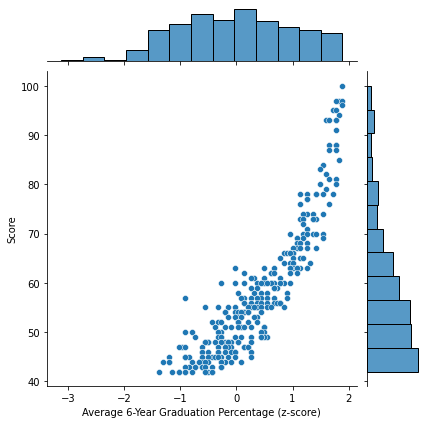

In [43]:
univ_df["rCAvgPctGrad6YrZScore"] = (univ_df["rCAvgPctGrad6Yr"] -univ_df["rCAvgPctGrad6Yr"].mean())/univ_df["rCAvgPctGrad6Yr"].std(ddof=0)
jp = sns.jointplot(x="rCAvgPctGrad6YrZScore",y="vDisplayScoreInt", data=univ_df)
jp.figure.axes[0].set(xlabel="Average 6-Year Graduation Percentage (z-score)", ylabel="Score")

That didn't change anything about the relationship. Another possible method of normalization is using percentiles -- does that "fix" the nonlinearity?

In [ ]:
from scipy import stats
univ_df["rCAvgPctGrad6YrPercentile"] = univ_df["rCAvgPctGrad6Yr"].apply(lambda x: stats.percentileofscore(univ_df["rCAvgPctGrad6Yr"], x))
jp = sns.jointplot(x="rCAvgPctGrad6YrPercentile",y="vDisplayScore", data=univ_df)
jp.figure.axes[0].set(xlabel="Average 6-Year Graduation Percentage (percentile)", ylabel="Score")

And we still see a non-linear relationship. This could indicate that US News uses a different normalization than expected, and doesn't explain how it works, or there is some other variable with a non-linear relationship to graduation rate that is also part of the rankings. Unfortunately, the limited data set doesn't allow much further analysis.

### Outcomes
(For outcomes) it compares against the "predicted rate for that cohort". To do this, they use factors including the 25th and 75th percentile ACT and SAT scores of those freshmen and the percentage of 2014 entering class students who placed in the top 10 of their year in their high school, among others [(as seen on the website)](https://www.usnews.com/media/best-colleges/graduation-rate-performance). 

- The five year non-weighted average of percentages of 2014-2015 through 2018- 2019 full-time, first-time undergraduates receiving Pell Grants, sourced from IPEDS.
- The natural log value of the two-year average of expenditures per student using data from fiscal years 2016 and 2017, sourced from U.S. News statistical surveys and IPEDS.
- The 25th and 75th percentile ACT and SAT scores of schools’ fall 2014 entering classes, sourced from U.S. News statistical surveys and IPEDS. For use in the model, the midpoint between the percentile scores for each exam (ACT composite, critical reading SAT, math SAT) was calculated, converted to its percentile distribution among test-takers, and weighted by the proportion of new entrant that took SAT and ACT. For any institution whose combined percentage of its fall 2014 class submitting ACT and SAT scores was less than 75% of new entrants, its percentile distribution was discounted by 0.85, as U.S. had done for its 2015 rankings calculations.
- The cubed value of the standardized tests value used in the model.
- The proportion of the 2016-2017 federal financial aid receiving undergraduates who were first-generation students; sourced from College Scorecard. 
- National Universities and National Liberal Arts Colleges incorporated the percentage of 2014 entering class students placing in the top 10 percent of their high school classes. Regional universities and colleges used percentages placing in the top 25 percent. The data were sourced from U.S. News statistical surveys. 
- National Universities only incorporated the percentage of 2016-2017 graduates awarded degrees in science, technology, engineering and mathematics (STEM) fields – mapped from the U.S. Department of Homeland Security’s NCES CIP code STEM designation.

#### TODO Calculate Cohort Data To The Best Approximation Possible 

In [ ]:
from collections import Counter

majors = univ_df["topMajors"][univ_df["topMajors"].notna()]
majors = [item[0] for major_univ in majors for item in major_univ]
major_count = Counter(majors)
#print(major_count)

## Other Predictors
Are there any other factors that correlate well with rank, despite not being used in the ranking calculation?

### Nested Values

TODO something something nested variables JSON normalize

In [ ]:
univ_df_num = univ_df.select_dtypes([np.number]).copy() # remove columns which are non-numeric
univ_df_num.columns

### Non-Quantitative Data
If we want to use the data to predict rankings, the easiest values to use are those with quantitative values as opposed to text values (it's possible to use categorical data for this regression, but that would take a lot of individual analysis for each of the variables, which should not be necessary to get a meaningful regression and result). 

### Missing Data 

In addition, there are many data values which have very few data points, meaning that most of the universities have a missing (NaN) value. Let's see how much that this is an issue by looking at the distribution of the number of NaNs.

In [ ]:
univ_df_num.dropna(subset=["vDisplayScoreInt"], inplace=True) # remove all of the schools without a score 
df_nas = univ_df_num.isna().sum()
ax = sns.histplot(df_nas, discrete=True)
ax.set(xlabel="Number of Rows Missing Data") 

Most of the factors have no missing values, but there's a long tail where a large proportion of the row values are missing. 
We can also look at the percentage of values missing for each data. 

In [ ]:
# Get the *percent* of rows with missing data
df_nas[df_nas > 0].apply(lambda x: x/len(univ_df_norm)).sort_values().to_frame(name="Percent Missing")

Most of the largest values are specific to certain categories of colleges; for example, a school won't have an `earlyDecAcceptRate` value if they don't allow early decision admissions. Data like this is **Missing At Random (MAR)**, meaning that we can predict whether it's missing based on other known factors. We will deal with these issues later.



Since we're exploring, let's look at the correlation between all of the values, all put into a single heat map.

In [ ]:
corr = univ_df_norm.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, center=0, cmap='coolwarm',
            square=True, cbar_kws={"shrink": .3}, xticklabels=True, yticklabels=True)

### Imputation
Since now we're looking at all of the numeric variables, now we need to consider how we will deal with the missing values. One solution would be to just drop it (like we did with the display scores), but that would mean losing out on a lot of valuable data and possibly bias the results. A more sophisticated solution is *multiple imputation*, where we create multiple data sets where the missing values have been substituted with guesses based on the distribution of the non-missing values, then calculate the regression on those data sets and combine them. 

In [ ]:
from statsmodels.imputation import mice

# Create the formula for regression (use all other columns to predict score)
x_vars = list(univ_df_norm.columns)
x_vars.remove("vDisplayScoreInt")
fml = f"vDisplayScoreInt ~ {' + '.join(x_vars)}"

imp = mice.MICEData(univ_df_norm)
imp.update_all(20)
imp.plot_imputed_hist("vGiBill")

(A very red cell means a strong positive correlation, while a very blue cell means a strong negative correlation.)

Just looking at this (admittedly intimidating) graph tells us a lot about correlations. Many of these correlations are obvious -- for example, the four-year graduation rate directly correlates with the 6-year graduation rate, and measures by gender (e.g. female enrollment and sorority enrollment) also correlate well. One other correlations that stands out to me is the inverse relation between `pctPell` and `rCAvgPctGrad6Yr`:

In [ ]:
ax = sns.scatterplot(x="pctPell", y="rCAvgPctGrad6Yr", data=univ_df_num)
ax.set(x=univ_key["pctPell"], y=univ_key["rCAvgPctGrad6Yr"])

One would ordinarily expect that 

In [ ]:
result = mice.MICE(fml, sm.OLS, imp).fit(20,20)
result.summary()

In [ ]:
nan_threshold = 200 # arbitrary threshold of non-NaN values which are necessary in order to keep the variable
univ_df_norm.dropna(axis=1, thresh=nan_threshold, inplace=True) # remove columns with too many missing values
# TODO get rid of latitude, longitude, etc.
univ_df_norm

**TODO Say Anything Else About This**

In [ ]:
score_corrs = corr['vDisplayScoreInt'].sort_values()
score_corrs.head(10)

In [ ]:
score_corrs.tail(10)

Besides the already mentioned graduation rates (and ignoring the fact that score perfectly correlates with itself), we see two other factors that have a r-squared magnitude over 0.8: `gSat1600ScaleChart_satGridRng1600` (i.e. the percent of students that got a score of 1400-1600 on the SAT) and `rCAcceptRate` (the percent acceptance rate). 

TODO Write about multivariate nonlinear model

In [ ]:
# TODO right now, this is a linear model, which is not great 
x_vars = list(univ_df_num.columns)
x_vars.remove("vDisplayScoreInt")
result = smf.ols(formula=f"vDisplayScoreInt ~ {' + '.join(x_vars)}", data=univ_df_num).fit()
result.summary()

In [ ]:
low_p_value_factors = ["csAvgCostIncome_nptHi2", "vStudentFacultyRatio", "gSat1600ScaleChart_satGridRng1600", 
                       "gStudentsOnOffCampus_stuCatLiveOffCampusUg", "csAvgCost", "totalAllStudents"] 
plot_factors_against_score(low_p_value_factors, 2, df=univ_df_norm)
#sns.scatterplot(x=, y="vDisplayScoreInt", data=univ_df_norm)
#univ_df_norm["csAvgCostIncome_nptHi2"]

In [ ]:
#
#univ_df["vPctUnderMen"]
#pd.json_normalize(univ_df.loc[:,["gStudentGenderDistribution","vDisplayScore"]])
#univ_df["gStudentGenderDistribution"]

#sns.scatterplot(x="vPctUnderMen", y="vDisplayScore", data=univ_df)

[TODO]

In [ ]:
other_factors = ["csAvgCost", "csTypicalDebt", "avgGradDebt", "vPrivateTuition"] #"pctPell"]
plot_factors_against_score(other_factors, 2)

Interestingly, in this data, we can see there's a relationship between score and tuition/fees, but there's also a weak *inverse* linear correlations between loan indebtedness and school rank. In other words, people who go to more prestigious universities leave with *less* debt than their peers on average, despite the fact their schools have higher tuitions! 

There are multiple reasons this could be true -- it could be because they are more likely to get scholarships, either from the school or from external sources, or it could be that the students at higher-ranked universities are from families with more wealth than on average.  

In [ ]:
other_factors = ["totalUndergrads", "totalGradsAndPros", "stuCatFraternityUg", "stuCatSororityUg"]
plot_factors_against_score(other_factors, 2)

TODO: Remove the points where no fraternities or sororities

## Rank Versus Salary

First, let's ask a simple question: does the ranking done by US News correlate with other metrics of success, like starting salary? Unfortunately, because this scraper doesn't by itself get the data about average salary, I need to supplement this with another web scraper I wrote which directly reads from the webpage (**link**). 

In [ ]:
ax = sns.scatterplot(data=univ_df, x="payscaleOverallStarting", y="vDisplayScore")
ax.set(title="Median Alumni Starting Salary vs University Scores",xlabel="Median Salary of Recent Alumni (USD)",ylabel="US News Score (0-100)")

In [ ]:
ax = sns.scatterplot(data=univ_df, x="payscaleOverallStarting", y="rCAvgPctGrad6Yr")

We can see a decent positive linear correlation, as we'd expect.

We can quantify the relationship with a predictive model:

In [ ]:
reg = smf.ols("vDisplayScore ~ payscaleOverallStarting", data=univ_df).fit()
reg.summary()

An r-squared of 0.518 means that there is some correlation, but it's not particularly strong.

#### Part 2.1.1: Considering Major

However, the school one attends is obviously not the only factor that controls your salary. One huge factor is your field -- chemical engineers, on average, earn significantly more than English teachers. Fortunately, this data set also has data regarding the ten most popular majors in each university. Let's, for example, look at the most popular majors at the universities with the 10 highest and lowest average starting salaries:

In [ ]:
univ_df_sal_maj = univ_df[["topMajors","payscaleOverallStarting","displayName"]].copy()
univ_df_sal_maj = univ_df_sal_maj[univ_df_sal_maj["topMajors"].map(lambda d: len(d) > 0)]
univ_df_sal_maj.sort_values("payscaleOverallStarting", inplace=True, ignore_index=True)

pd.set_option('display.max_colwidth', None)
univ_df_sal_maj.head(10)

In [ ]:
univ_df_sal_maj.tail(10)

We can see generally, the highest-salary schools have high representation of computer science and engineering field, while there are a surprising number of Business degrees at the lowest-salaried universities. 
# TODO Use This Information Somehow